In [1]:
from pydub import AudioSegment
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix

In [2]:
import torch
import torchaudio
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from pydub import AudioSegment
from sklearn.model_selection import train_test_split

In [3]:
import os
result = os.environ['PATH']
os.environ['PATH'] += os.pathsep + 'C:\\Program Files\\ffmpeg-2024-09-22-git-a577d313b2-full_build\\bin'

In [4]:
# load audio files 
path_to_jayesh_drinking = "DrinkingAudio\\JayeshDrinking\\"
path_to_jayesh_not_drinking = "DrinkingAudio\\JayeshDrinking\\SilentRecording\\"
path_to_elvis_drinking = "DrinkingAudio\\ElvisDrinking\\"
path_to_elvis_not_drinking = "DrinkingAudio\\ElvisDrinking\\SilentRecording\\"

In [42]:
# load jayesh m4a files 
jayesh_drinking_files = [f for f in os.listdir(path_to_jayesh_drinking) if f.endswith('.m4a')]
jayesh_not_drinking_files = [f for f in os.listdir(path_to_jayesh_not_drinking) if f.endswith('.m4a')]

# load elvis mp4 files
elvis_drinking_files = [f for f in os.listdir(path_to_elvis_drinking) if f.endswith('.mp4')]
elvis_not_drinking_files = [f for f in os.listdir(path_to_elvis_not_drinking) if f.endswith('.mp4')]

In [43]:
# create function to load audio files using pydub
def load_audio_file(file_path):
    audio = AudioSegment.from_file(file_path)
    audio = audio.set_frame_rate(16000)
    # audio = audio.set_channels(1)
    return audio

# load audio files
jayesh_drinking_waveforms = [load_audio_file(path_to_jayesh_drinking + f)[0] for f in jayesh_drinking_files]
jayesh_not_drinking_waveforms = [load_audio_file(path_to_jayesh_not_drinking + f)[0] for f in jayesh_not_drinking_files]
elvis_drinking_waveforms = [load_audio_file(path_to_elvis_drinking + f)[0] for f in elvis_drinking_files]
elvis_not_drinking_waveforms = [load_audio_file(path_to_elvis_not_drinking + f)[0] for f in elvis_not_drinking_files]

In [51]:
# plot the elvis drinking waveform for the first sample, plot the 2 channels separately
waveform0 = elvis_drinking_waveforms[0][0]
waveform1 = elvis_drinking_waveforms[0][1]
# convert to numpy array
waveform0 = np.array(waveform0.get_array_of_samples())
waveform1 = np.array(waveform1.get_array_of_samples())
# convert to float
waveform0 = waveform0.astype(float)
waveform1 = waveform1.astype(float)


ParameterError: Input is too short (n=0) for frame_length=1

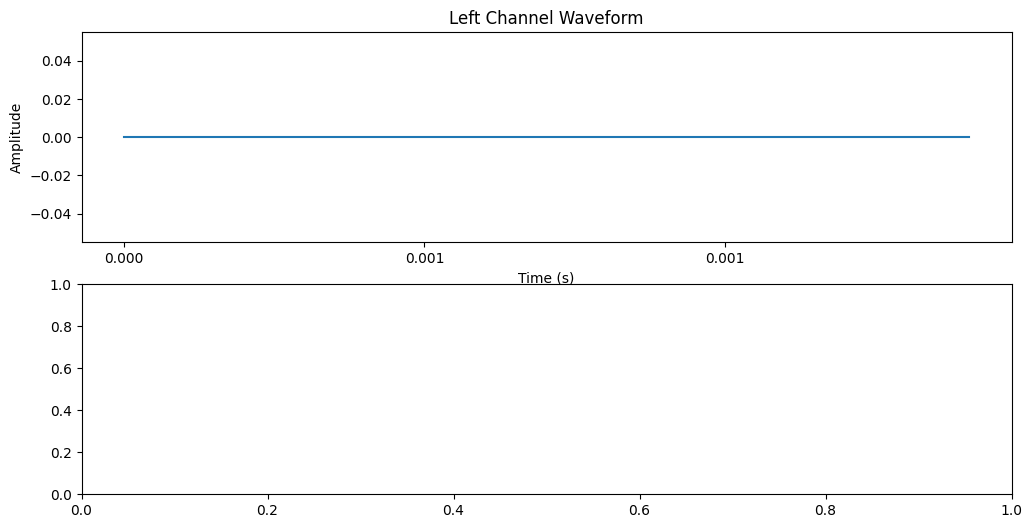

In [52]:
plt.figure(figsize=(12, 6))
# Plot left channel
plt.subplot(2, 1, 1)
librosa.display.waveshow(waveform0, sr=sr)
plt.title('Left Channel Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot right channel
plt.subplot(2, 1, 2)
librosa.display.waveshow(waveform1, sr=sr)
plt.title('Right Channel Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Display the plot
plt.tight_layout()
plt.show()

In [44]:
# count number of samples\
print("Jayesh Drinking: ", len(jayesh_drinking_waveforms))
print("Jayesh Not Drinking: ", len(jayesh_not_drinking_waveforms))
print("Elvis Drinking: ", len(elvis_drinking_waveforms))
print("Elvis Not Drinking: ", len(elvis_not_drinking_waveforms))

Jayesh Drinking:  11
Jayesh Not Drinking:  26
Elvis Drinking:  25
Elvis Not Drinking:  75


In [8]:
# get total ratio of drinking to not drinking
total_drinking = len(jayesh_drinking_waveforms) + len(elvis_drinking_waveforms)
total_not_drinking = len(jayesh_not_drinking_waveforms) + len(elvis_not_drinking_waveforms)
total_ratio = total_drinking / total_not_drinking
print("Total Drinking to Not Drinking Ratio: ", total_ratio)

Total Drinking to Not Drinking Ratio:  0.26732673267326734


In [9]:
# check channels length of audio files
jayesh_drinking_waveforms[0].channels

1

In [10]:
elvis_drinking_waveforms[0].channels

1

In [32]:
# Data augmentation function
def augment_audio(audio, augment_type="pitch_shift"):
    samples = np.array(audio.get_array_of_samples())
    
    if augment_type == "pitch_shift":
        # Pitch shifting
        n_steps = random.randint(-6, 6)  # Shift pitch by up to 2 steps
        shifted = librosa.effects.pitch_shift(samples.astype(float), sr=audio.frame_rate, n_steps=n_steps)
        return AudioSegment(
            shifted.astype(np.int16).tobytes(), 
            frame_rate=audio.frame_rate, 
            sample_width=audio.sample_width,
            channels=audio.channels
        )
    elif augment_type == "add_noise":
        # Adding noise
        noise = np.random.normal(0, 0.20, len(samples))  # Adjust the noise level as needed
        noisy = samples + noise
        return AudioSegment(
            noisy.astype(np.int16).tobytes(), 
            frame_rate=audio.frame_rate, 
            sample_width=audio.sample_width,
            channels=audio.channels
        )
    elif augment_type == "volume_adjust":
        # Adjusting volume
        volume_change = random.uniform(-10, 15)  # Change volume by -5 to +5 dB
        return audio + volume_change  # Adjust volume
    else:
        return audio  # No augmentation

# Load audio files and apply augmentation
def load_and_augment_audio_file(file_path):
    audio = AudioSegment.from_file(file_path)
    audio = audio.set_frame_rate(16000)
    audio = audio.set_channels(1)

    # Apply augmentation (you can use multiple augmentations)
    augmented_audios = [audio]
    for _ in range(2):  # Create two augmented versions for each original
        aug_type = random.choice(["pitch_shift", "add_noise", "volume_adjust"])  # Randomly choose an augmentation type
        augmented_audio = augment_audio(audio, augment_type=aug_type)
        augmented_audios.append(augmented_audio)

    return augmented_audios

# Load and augment audio files
jayesh_drinking_waveforms = [load_and_augment_audio_file(path_to_jayesh_drinking + f) for f in jayesh_drinking_files]
jayesh_not_drinking_waveforms = [load_and_augment_audio_file(path_to_jayesh_not_drinking + f) for f in jayesh_not_drinking_files]
elvis_drinking_waveforms = [load_and_augment_audio_file(path_to_elvis_drinking + f) for f in elvis_drinking_files]
elvis_not_drinking_waveforms = [load_and_augment_audio_file(path_to_elvis_not_drinking + f) for f in elvis_not_drinking_files]

# Flatten the list of augmented waveforms
jayesh_drinking_waveforms = [item for sublist in jayesh_drinking_waveforms for item in sublist]
jayesh_not_drinking_waveforms = [item for sublist in jayesh_not_drinking_waveforms for item in sublist]
elvis_drinking_waveforms = [item for sublist in elvis_drinking_waveforms for item in sublist]
elvis_not_drinking_waveforms = [item for sublist in elvis_not_drinking_waveforms for item in sublist]

# Now you can proceed to extract MFCCs and continue with the rest of the workflow


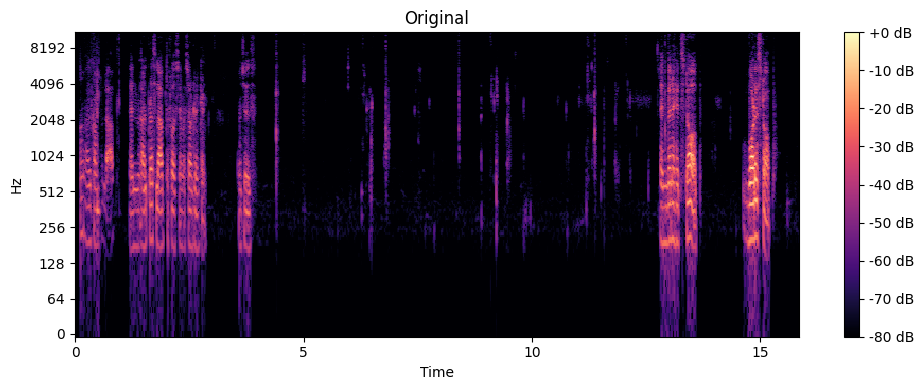

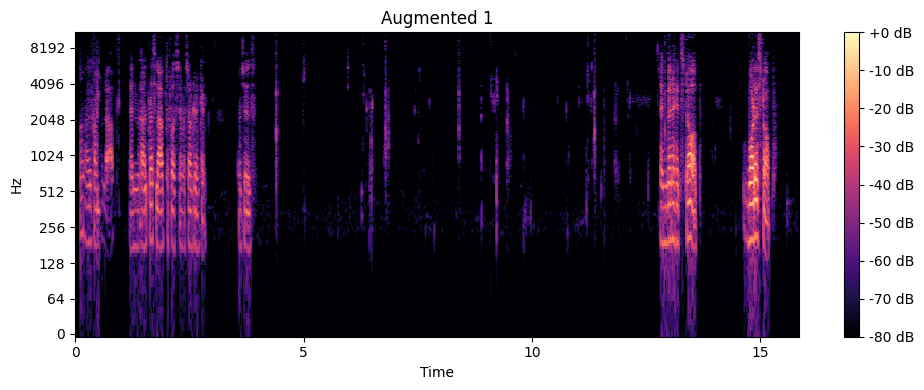

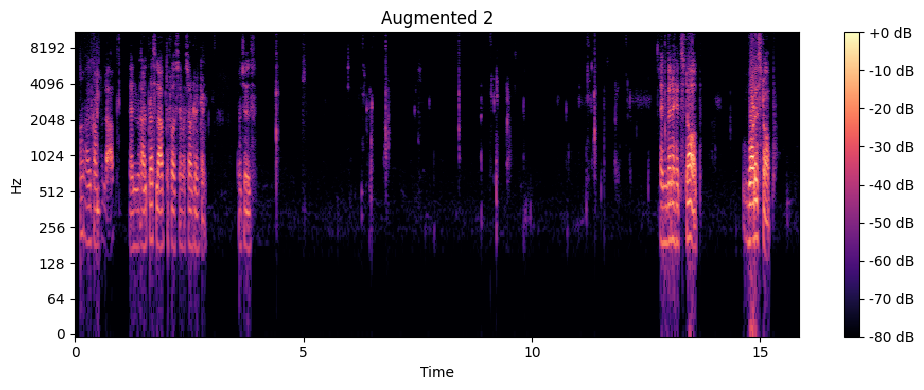

In [33]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Function to plot spectrogram for a single waveform
def plot_spectrogram(waveform, sr, title):
    
    waveform = np.array(waveform.get_array_of_samples())
    # convert to floating point number
    waveform = waveform.astype(float)
    
    # Compute STFT
    D = librosa.stft(waveform)
    S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
    
    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Function to plot spectrograms of original and augmented audios
def plot_original_and_augmented_spectrograms(original_waveform, augmented_waveform1, augmented_waveform2, sr):
    plot_spectrogram(original_waveform, sr, "Original")
    plot_spectrogram(augmented_waveform1, sr, "Augmented 1")
    plot_spectrogram(augmented_waveform2, sr, "Augmented 2")

# Assuming you have the correct sampling rate
sr = 22050  # Set this to the correct sampling rate

plot_original_and_augmented_spectrograms(jayesh_drinking_waveforms[3], jayesh_drinking_waveforms[4], jayesh_drinking_waveforms[5], sr)





In [34]:
def extract_mfcc(audio, max_duration=40, sr=16000, n_mfcc=13):
    # Convert pydub AudioSegment to numpy array of samples
    samples = np.array(audio.get_array_of_samples()).astype(np.float32) / 32768.0  # Normalize to [-1, 1]
    
    # If audio is too long, truncate to 40 seconds
    max_samples = sr * max_duration
    if len(samples) > max_samples:
        samples = samples[:max_samples]
    
    # If audio is too short, pad with zeros
    if len(samples) < max_samples:
        padding = np.zeros(max_samples - len(samples))
        samples = np.concatenate([samples, padding])
    
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=samples, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T  # Transpose so that we have (time, n_mfcc)

# Extract MFCCs for each set of waveforms
jayesh_drinking_mfccs = [extract_mfcc(audio) for audio in jayesh_drinking_waveforms]
jayesh_not_drinking_mfccs = [extract_mfcc(audio) for audio in jayesh_not_drinking_waveforms]
elvis_drinking_mfccs = [extract_mfcc(audio) for audio in elvis_drinking_waveforms]
elvis_not_drinking_mfccs = [extract_mfcc(audio) for audio in elvis_not_drinking_waveforms]

# Step 4: Combine the data into one dataset (with labels: 1 for drinking, 0 for not drinking)
# Drinking = 1, Not drinking = 0
all_mfccs = jayesh_drinking_mfccs + jayesh_not_drinking_mfccs + elvis_drinking_mfccs + elvis_not_drinking_mfccs
all_labels = [1] * len(jayesh_drinking_mfccs) + [0] * len(jayesh_not_drinking_mfccs) + \
             [1] * len(elvis_drinking_mfccs) + [0] * len(elvis_not_drinking_mfccs)

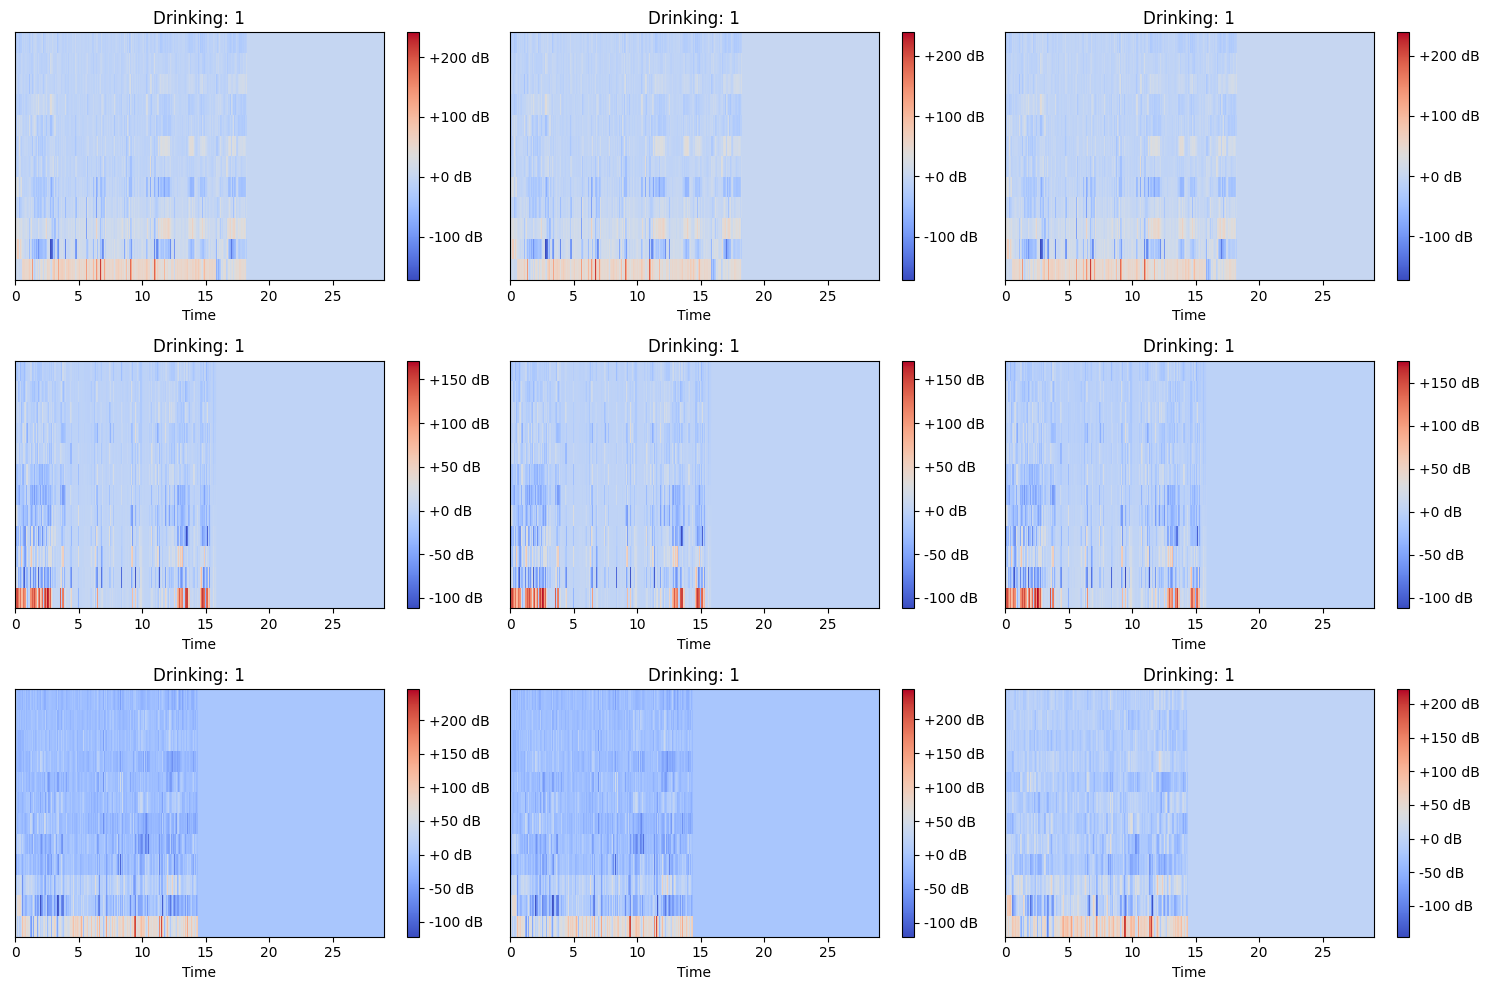

In [35]:
# plot the first 9 audio files along with their augmented versions to see the difference using MFCC

plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    # dont plot the first mfcc coeff
    mfcc = all_mfccs[i][:, 1:]
    librosa.display.specshow(mfcc.T, x_axis='time')
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Drinking: {all_labels[i]}")
    plt.tight_layout()

In [36]:
X_train, X_test, y_train, y_test = train_test_split(all_mfccs, all_labels, test_size=0.25, random_state=42, stratify=all_labels)

# Modify __getitem__ in AudioDataset class to reshape the MFCCs
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        mfcc = self.X[idx]
        label = self.y[idx]
        
        # Add a channel dimension (for CNN input)
        mfcc = np.expand_dims(mfcc, axis=0)  # This adds a 1-channel dimension
        
        return torch.tensor(mfcc, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

batch_size = 32

train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

# Step 5: Create DataLoader instances for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the sizes of the training and testing datasets
print(f'Training set size: {len(train_dataset)}')
print(f'Testing set size: {len(test_dataset)}')


Training set size: 288
Testing set size: 96


In [37]:
# Define the CNN model
class AudioClassifierCNN(nn.Module):
    def __init__(self):
        super(AudioClassifierCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Initialize the fully connected layer size dynamically
        self.fc1 = nn.Linear(self._get_conv_output_size(), 128)
        self.fc2 = nn.Linear(128, 2)  # Assuming binary classification

    def _get_conv_output_size(self):
        # Create a dummy input to calculate the size after convolution layers
        dummy_input = torch.zeros(1, 1, 1251, 13)  # Sample input shape
        x = self.pool(F.relu(self.bn1(self.conv1(dummy_input))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return int(torch.prod(torch.tensor(x.size()[1:])))

    def forward(self, x):
        # Apply convolutional layers with ReLU activations and max pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten the input dynamically
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation for output (CrossEntropyLoss will be applied later)

        return x


# Create the model instance
model = AudioClassifierCNN()


In [38]:
# Define loss function (Cross-Entropy Loss for classification)
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)


c:\Users\Jayesh\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [1/10], Loss: 1.3405, Accuracy: 78.47%
Epoch [2/10], Loss: 0.2610, Accuracy: 87.85%
Epoch [3/10], Loss: 0.1964, Accuracy: 91.32%
Epoch [4/10], Loss: 0.1206, Accuracy: 96.18%
Epoch [5/10], Loss: 0.0917, Accuracy: 97.92%
Epoch [6/10], Loss: 0.0498, Accuracy: 98.61%
Epoch [7/10], Loss: 0.0365, Accuracy: 99.65%
Epoch [8/10], Loss: 0.0255, Accuracy: 99.65%
Epoch [9/10], Loss: 0.0139, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0084, Accuracy: 100.00%


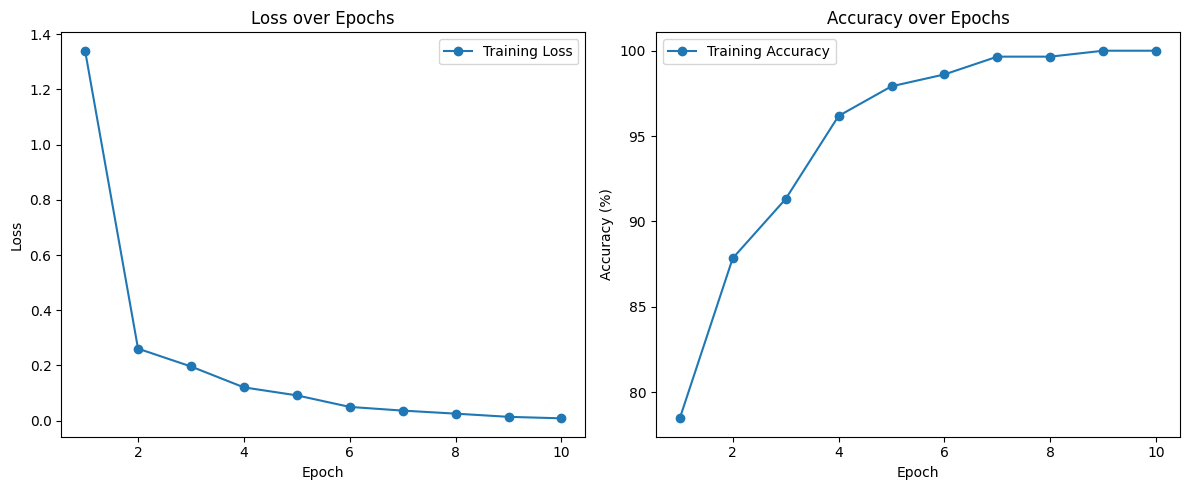

In [39]:
# Number of epochs and batch size
num_epochs = 10

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Lists to store the loss and accuracy values for plotting
train_loss_history = []
train_accuracy_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Compute loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    # Store the values for plotting
    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_accuracy)
    
    # Print epoch stats
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Plotting the Loss and Accuracy over epochs
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_history, marker='o', label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracy_history, marker='o', label='Training Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [58]:
# Initialize empty lists to store true and predicted labels
all_labels = []
all_predictions = []

model.eval()  # Set model to evaluation mode (no gradients)
correct = 0
total = 0

with torch.no_grad():  # No need to compute gradients
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Accumulate total correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and true labels for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Compute test accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Test Accuracy: 95.83333333333333%
Confusion Matrix:
[[72  4]
 [ 0 20]]


In [59]:
# show the 4 false positives
false_positives = []
for i in range(len(all_labels)):
    if all_labels[i] == 0 and all_predictions[i] == 1:
        false_positives.append(i)

In [63]:
print("False Positives: ", false_positives)

False Positives:  [32, 55, 56, 79]
